# Image classification with convolutional neural networks

In this script we create, train, and evaluate an image classifier based on convolutional neural networks (CNNs).

In [64]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [65]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

## Dataset

In this lab we work with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset: it's similar to MNIST, but these are images of clothes from Zalando instead of digits.

<center><a href="https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5">
    <img src="https://miro.medium.com/max/1400/1*jXssb_WjoYZgepOCfdQfJA.png" width="400"></a></center>

Like MNIST, each image comes with a label between 0 and 9 (10 classes). The mapping between integer labels and actual classes (0 = t-shirt, 1 = trousers, etc.) can be found [here](https://github.com/zalandoresearch/fashion-mnist#labels).

In [66]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Just like MNIST, you can download the data by setting 'download=True' directly from pytorch
train_data = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=torchvision.transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

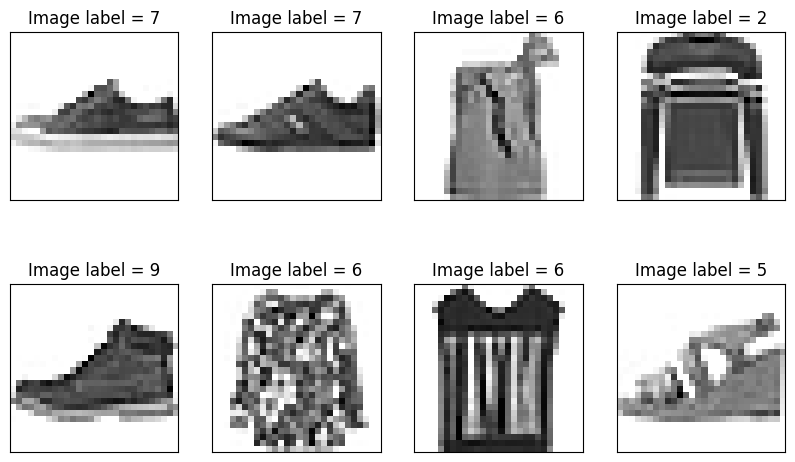

In [5]:
# Get a batch of images from the train dataloader and print it
image_batch_example, labels_batch_example = next(iter(train_dataloader))

plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze().detach(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## CNN classifier

A CNN classifier usually consists of:
- one or several convolutional layers/modules that produce intermediate latent representations called ***feature maps***
- an output linear layer performing classification from the feature maps

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png"></a></center>

### Example

In [67]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [68]:
# TO DO: create the second CNN layer, with the same structure as the first one
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.
cnn_layer2 = nn.Sequential(
    nn.Conv2d(16, 32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
)
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([8, 32, 7, 7])


In [69]:
# Now, we define a linear layer to perform classification (as in Lab 3)

# First, we need to flatten out2, since linear layers in pytorch process vectors (or more precisely batches of vectors)
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate parameters
# - the input size is given by checking the shape of 'out_vec'
# - the output size is the number of classes in the dataset
# Once defined, apply this layer to out_vec
input_size_linear = out_vec.shape[1]  # 32 * 7 * 7 = 1568
output_size = num_classes   # 10
linear_layer = nn.Linear(input_size_linear, output_size)
# apply linear layer
out_f = linear_layer(out_vec)
print(out_f.shape)

torch.Size([8, 1568])
torch.Size([8, 10])


### General module

Now, let's create a general CNN classification network, train and test it. The CNN module takes as inputs the number of output channels in each layer (and the number of classes), but we also have to explicitly provide the input size of the Linear layer, since it depends on many other parameters (image size, but also kernel, padding, stride, number of channels in the convolutions...). Instead of computing it with a general (and heavy) formula, it's easier to just get it from an example (as above), and then pass it as an input parameter.

**Note**: there are ways to alleviate this issue (e.g., using another convolution layer with as many kernels as output classes, and then global pooling)... but that's outside the scope of these labs.

In [70]:
# TO DO: Define the CNN classifier module ('__init__' and 'forward' methods).
# It's architecture (=layers) is the same as in the example above.
# Define the CNN classifier module
class CNNClassif(nn.Module):
    def __init__(self, input_size_linear, num_channels1, num_channels2, num_classes):
        super(CNNClassif, self).__init__()
        
        # first CNN layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # second CNN layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
         # linear layer
        self.fc = nn.Linear(input_size_linear, num_classes)
        
    def forward(self, x):
        # appy layers
        x = self.conv1(x)
        x = self.conv2(x) 
        # flatten the output
        x = x.reshape(x.shape[0], -1)
        # the linear layer
        x = self.fc(x)
        return x

In [71]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
model.apply(init_params)

Total number of parameters:  28938


CNNClassif(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

## Training and evaluation

The evaluation and training function (with validation) are almost the same as in lab4.1, except we don't need to vectorize the images. Indeed, MLPs process (batches of) vectors, while CNNs directly process (batches of) images.

<span style="color:red">**Exercice 3**</span> Write the evaluation and training function with validation. Train the model using the training parameters below, and plot the training loss and validation accuracy over epochs. Compute the test accuracy.

In [72]:
def training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # copy of the model
    model_tr = copy.deepcopy(model)
    model_tr.train()  # training mode
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)  # the optimizer (SGD)

    train_losses = []
    valid_accuracies = []
    
    # training loop
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # forward
            y_predicted = model_tr(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update the current epoch loss
            tr_loss += loss.item() * images.shape[0]

        # avg training loss
        tr_loss = tr_loss / len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        
        # validation
        model_tr.eval()  # evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_dataloader:
                outputs = model_tr(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_accuracy = 100 * correct / total
        valid_accuracies.append(valid_accuracy)
        
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {tr_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')
            
        model_tr.train()  # training mode

    return model_tr, train_losses, valid_accuracies

In [73]:
# Training parameters
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Train the model
trained_model, train_losses, valid_accuracies = training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_cnn_classification.pt')

Epoch [1/40], Loss: 2.3270, Validation Accuracy: 7.00%
Epoch [2/40], Loss: 2.2922, Validation Accuracy: 7.00%
Epoch [3/40], Loss: 2.2646, Validation Accuracy: 13.00%
Epoch [4/40], Loss: 2.2394, Validation Accuracy: 12.00%
Epoch [5/40], Loss: 2.2139, Validation Accuracy: 12.00%
Epoch [6/40], Loss: 2.1870, Validation Accuracy: 13.00%
Epoch [7/40], Loss: 2.1571, Validation Accuracy: 13.00%
Epoch [8/40], Loss: 2.1228, Validation Accuracy: 19.00%
Epoch [9/40], Loss: 2.0831, Validation Accuracy: 19.00%
Epoch [10/40], Loss: 2.0351, Validation Accuracy: 21.00%
Epoch [11/40], Loss: 1.9779, Validation Accuracy: 26.00%
Epoch [12/40], Loss: 1.9104, Validation Accuracy: 29.00%
Epoch [13/40], Loss: 1.8304, Validation Accuracy: 38.00%
Epoch [14/40], Loss: 1.7396, Validation Accuracy: 41.00%
Epoch [15/40], Loss: 1.6421, Validation Accuracy: 48.00%
Epoch [16/40], Loss: 1.5366, Validation Accuracy: 44.00%
Epoch [17/40], Loss: 1.4380, Validation Accuracy: 49.00%
Epoch [18/40], Loss: 1.3405, Validation Ac

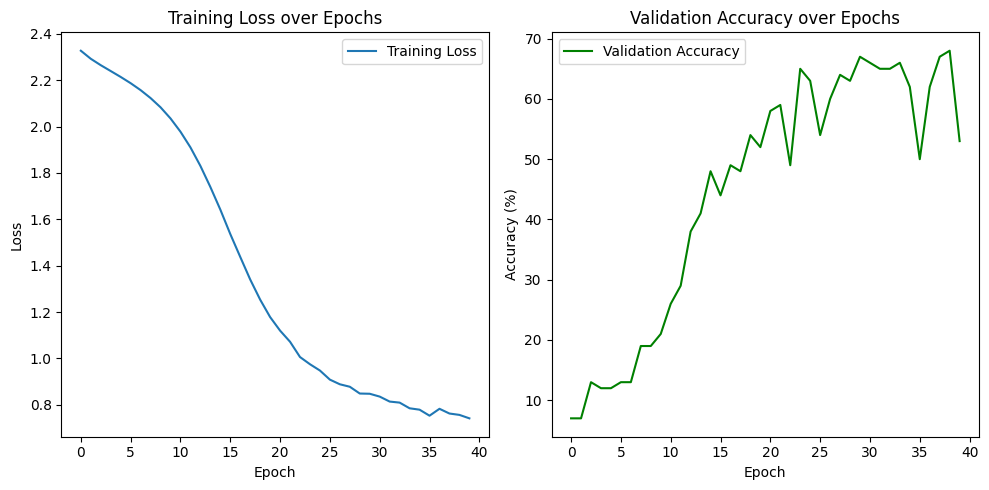

In [74]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the validation accuracy over epochs
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(valid_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

In [75]:
# test function for the trained model
def test_cnn_classifier(model, test_dataloader):
    model.eval()  #  evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy

In [76]:
# test the model
test_accuracy = test_cnn_classifier(trained_model, test_dataloader)

Test Accuracy: 64.00%


## Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use **batch normalization**, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Batch norm is easy to write in Pytorch (see the [doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)).

**Note**: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [77]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each CNN layer, between RELU and Maxpooling.
class CNNClassifWithBN(nn.Module):
    def __init__(self, input_size_linear, num_channels1, num_channels2, num_classes, use_batch_norm=False):
        super(CNNClassifWithBN, self).__init__()
        self.use_batch_norm = use_batch_norm
        
        # first CNN layer with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1) if use_batch_norm else nn.Identity(),  # batch Normalization
            nn.MaxPool2d(kernel_size=2)
        )
        
        # second CNN layer with batch normalization
        self.conv2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2) if use_batch_norm else nn.Identity(),  # batch Normalization
            nn.MaxPool2d(kernel_size=2)
        )
        
        # linear layer
        self.fc = nn.Linear(input_size_linear, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)  
        x = self.conv2(x)  
        x = x.reshape(x.shape[0], -1)  # flatten the tensor
        x = self.fc(x)
        return x

In [78]:
# TO DO:
# - instantiate the model and initialize its parameters
# - train it, and plot the training and validation losses
# - compute and print the test accuracy

# instantiate the model
model_bn = CNNClassifWithBN(input_size_linear, num_channels1, num_channels2, num_classes, use_batch_norm=True)
model_bn.apply(init_params)
optimizer_bn = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)
# training
trained_model_bn, train_losses_bn, valid_accuracies_bn = training_cnn_classifier(model_bn, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/40], Loss: 1.8162, Validation Accuracy: 26.00%
Epoch [2/40], Loss: 0.8247, Validation Accuracy: 68.00%
Epoch [3/40], Loss: 0.5995, Validation Accuracy: 68.00%
Epoch [4/40], Loss: 0.4763, Validation Accuracy: 64.00%
Epoch [5/40], Loss: 0.3964, Validation Accuracy: 69.00%
Epoch [6/40], Loss: 0.3401, Validation Accuracy: 72.00%
Epoch [7/40], Loss: 0.2685, Validation Accuracy: 70.00%
Epoch [8/40], Loss: 0.2446, Validation Accuracy: 71.00%
Epoch [9/40], Loss: 0.2141, Validation Accuracy: 70.00%
Epoch [10/40], Loss: 0.1864, Validation Accuracy: 71.00%
Epoch [11/40], Loss: 0.1670, Validation Accuracy: 71.00%
Epoch [12/40], Loss: 0.1508, Validation Accuracy: 72.00%
Epoch [13/40], Loss: 0.1318, Validation Accuracy: 71.00%
Epoch [14/40], Loss: 0.1187, Validation Accuracy: 75.00%
Epoch [15/40], Loss: 0.1135, Validation Accuracy: 74.00%
Epoch [16/40], Loss: 0.1018, Validation Accuracy: 74.00%
Epoch [17/40], Loss: 0.0942, Validation Accuracy: 74.00%
Epoch [18/40], Loss: 0.0901, Validation 

In [79]:
# Compute test accuracy
test_accuracy = test_cnn_classifier(trained_model_bn, test_dataloader)

Test Accuracy: 92.00%


<span style="color:red">**Exercice 4**</span> On a single plot, display the training loss with and without batch norm. On another plot, display the validation accuracy with and without batch norm. What do you conclude?



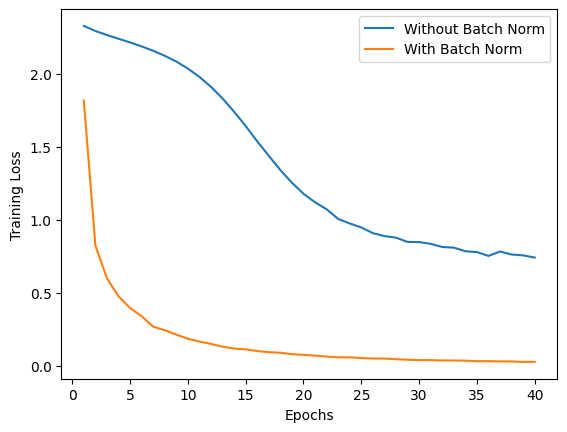

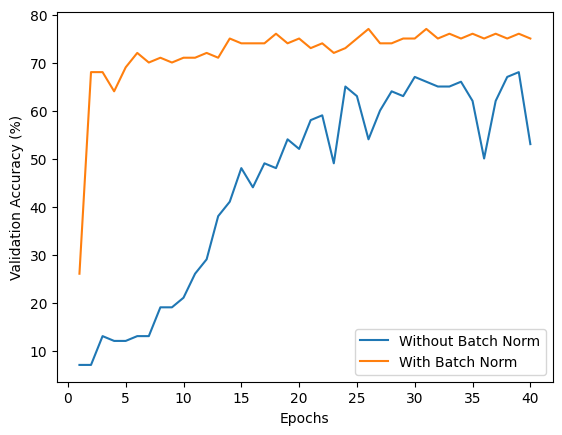

In [80]:
import numpy as np

# Plot training loss with and without batch norm
plt.figure()
plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Without Batch Norm')
plt.plot(np.arange(1, num_epochs + 1), train_losses_bn, label='With Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Plot validation accuracy with and without batch norm
plt.figure()
plt.plot(np.arange(1, num_epochs + 1), valid_accuracies, label='Without Batch Norm')
plt.plot(np.arange(1, num_epochs + 1), valid_accuracies_bn, label='With Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()